<a href="https://colab.research.google.com/github/Pravallika-Myneni/Data_science_pipeline/blob/main/Clustering_techniques_chicago_pm_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/crime_merged.csv', index_col = [0])
df.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Other Asian,Native Hawaiian and Other Pacific Islander,Native Hawaiian,Chamorro,Samoan,Other Pacific Islander,Some other race,ZipCode,Median_Income,Mean_Income
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,96,36,9,0,10,17,2103,60644,28033,44694
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,249,0,0,0,0,0,150,60661,125365,148266


In [4]:
df['Date'].value_counts()

01/01/2016 12:01:00 AM    132
01/01/2017 12:01:00 AM     99
01/01/2018 12:01:00 AM     97
01/01/2017 12:00:00 AM     96
05/31/2020 04:00:00 PM     90
                         ... 
10/16/2016 11:44:00 PM      1
03/29/2020 11:01:00 PM      1
05/14/2015 12:24:00 PM      1
03/29/2020 04:08:00 PM      1
09/09/2022 12:13:00 PM      1
Name: Date, Length: 880517, dtype: int64

In [5]:
df['Community Area'].nunique()

77

In [6]:
community_value_counts = df['Community Area'].value_counts()
community_value_counts

25.0    111192
8.0      79031
28.0     63918
32.0     63788
43.0     63624
         ...  
55.0      4385
74.0      4160
12.0      3841
47.0      2785
9.0       2006
Name: Community Area, Length: 77, dtype: int64

In [7]:
df['ID'].nunique(), df.shape

(1884111, (1884111, 58))

In [8]:
df.groupby(['Community Area', 'Date']).count()['ID'].groupby(level = 0).count()

Community Area
1.0     27062
2.0     24106
3.0     24795
4.0     13590
5.0      9274
        ...  
73.0    21926
74.0     4063
75.0    14139
76.0    11465
77.0    18059
Name: ID, Length: 77, dtype: int64

In [9]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'clean block', 'zipcode', 'Unnamed: 0.1', 'Zipcode',
       'SEX AND AGE', 'Total population', 'Male', 'Female',
       'Total population.1', 'One race', 'Two or more races', 'One race.1',
       'White', 'Black or African American',
       'American Indian and Alaska Native', 'Cherokee tribal grouping',
       'Chippewa tribal grouping', 'Navajo tribal grouping',
       'Sioux tribal grouping', 'Asian', 'Asian Indian', 'Chinese', 'Filipino',
       'Japanese', 'Korean', 'Vietnamese', 'Other Asian',
       'Native Hawaiian and Other Pacific Islander', 'Native Hawaiian',
       'Chamorro', 'Samoan', 'Other Pacific Islander', 'Some other race',
       'ZipCode', 'Median_Income', 'Mean_I

In [10]:
df_ = df[[ 'Latitude', 'Longitude', 'ID', 'Case Number' , 'Date', 'Block', 'IUCR', 'Primary Type', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'Zipcode', 'Median_Income', 'Mean_Income']].rename(columns = {'Date' : 'DateTime'})
df_['DateTime'] = pd.to_datetime(df_['DateTime'])
df_['Date'] = df_['DateTime'].dt.date
df_ = df_.rename(columns =  {col : col.replace(' ', '_') for col in df.columns})
df_['week'] = df_['DateTime'].dt.week
df_['day'] = df_['DateTime'].dt.day
df_['month'] = df_['DateTime'].dt.month
df_.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


,Latitude,Longitude,ID,Case_Number,DateTime,Block,IUCR,Primary_Type,Arrest,Domestic,...,Ward,Community_Area,FBI_Code,Zipcode,Median_Income,Mean_Income,Date,week,day,month
0,41.815117,-87.6700,10224738,HY411648,2015-09-05 13:30:00,043XX S WOOD ST,0486,BATTERY,False,True,...,12.0,61.0,08B,60644,28033,44694,2015-09-05,36,5,9
1,41.895080,-87.7654,10224739,HY411615,2015-09-04 11:30:00,008XX N CENTRAL AVE,0870,THEFT,False,False,...,29.0,25.0,06,60661,125365,148266,2015-09-04,36,4,9


In [11]:
pd.date_range(start="2015-01-01", end="2022-09-23").difference(df_.Date)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

May be before clustering, we can rank the ofns_Desc and use that as one more attribute for clustering..

we can use other attributes as well here

# Clustering into high threat - medium threat and low threat zones

In [12]:
clustering_df = df_.copy()[['Community_Area', 'ID', 'Arrest', 'Median_Income', 'Mean_Income']]
total = clustering_df.groupby(['Community_Area']).agg({ 'ID' : 'count', 'Median_Income' : 'mean', 'Mean_Income' : 'mean', 'Arrest' : 'sum'}).rename(columns = {'ID' : 'Total_incidents'})
#arrest_wise = clustering_df.groupby(['Community_Area', 'Arrest']).count()['ID'].to_frame().reset_index()
#arrest_true = arrest_wise[arrest_wise['Arrest']== True].drop(columns = ['Arrest']).rename(columns = {'ID': 'Arrested_true'}).set_index('Community_Area')
#arrest_false = arrest_wise[arrest_wise['Arrest']== False].drop(columns = ['Arrest']).rename(columns = {'ID': 'Arrested_false'}).set_index('Community_Area')

crime_rate = total.copy()#.merge(arrest_false,left_index=True, right_index=True, how='inner')
#crime_rate = crime_rate.merge(arrest_true,left_index=True, right_index=True, how='inner')
crime_rate['arrest_rate'] = crime_rate['Arrest']/crime_rate['Total_incidents']
crime_rate.head(2)

clustering_df_ = crime_rate.copy().drop(columns = ['Total_incidents', 'Arrest'])

In [13]:
clustering_df_.describe()

,Median_Income,Mean_Income,arrest_rate
count,77.000000,77.000000,77.000000
mean,53689.313792,78249.856461,0.168177
std,21281.568599,31642.430974,0.058626
min,29521.269442,45816.079455,0.077063
25%,37513.814663,56089.069555,0.124316
50%,50233.573169,70909.137867,0.163951
75%,60737.377359,89744.782747,0.187678
max,154970.682448,239173.042923,0.390888


In [14]:
clustering_df_.head(2)

,Median_Income,Mean_Income,arrest_rate
Community_Area,,,
1.0,54592.21032,76435.966637,0.163951
2.0,41813.91285,63755.237821,0.122120


Is there a point to do this.. convert to str then encode it?? For now, assuming no

In [15]:
"""from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

clustering_df_['Zipcode'] = le.fit_transform(clustering_df_['Zipcode'])

clustering_df_.head(2)"""

"from sklearn.preprocessing import LabelEncoder\n\nle = LabelEncoder()\n\nclustering_df_['Zipcode'] = le.fit_transform(clustering_df_['Zipcode'])\n\nclustering_df_.head(2)"

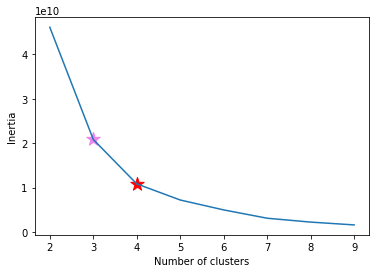

In [16]:
from sklearn.cluster import KMeans
X = np.array(clustering_df_)
inertias = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init = "k-means++")
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
plt.plot(range(2,10), inertias)
plt.scatter(3,inertias[1], s = 200, c = 'violet', marker='*')
plt.scatter(4,inertias[2], s = 200, c = 'red', marker='*')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [17]:
##It gives an idea of how well the objects are classified taking that number of clusters
from sklearn.metrics import silhouette_score
for n_clusters in range(2,10):
    clusterer = KMeans(n_clusters=n_clusters, init = "k-means++")
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score (X, preds, metric='euclidean', n_jobs=-1)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.6341198133562056)
For n_clusters = 3, silhouette score is 0.589971843354852)
For n_clusters = 4, silhouette score is 0.5577626482946033)
For n_clusters = 5, silhouette score is 0.5561058951582118)
For n_clusters = 6, silhouette score is 0.5334521448216812)
For n_clusters = 7, silhouette score is 0.5417449828432708)
For n_clusters = 8, silhouette score is 0.485064303350976)
For n_clusters = 9, silhouette score is 0.48220429578129664)


Silhouetee score is takiing ages to calculate.. try again later?

In [75]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score

In [76]:
kmeans = KMeans(n_clusters=3, init = "k-means++")
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
pred = y_kmeans
kmeans = clustering_df_.copy()
kmeans['Label'] = pred
#kmeans = kmeans.reset_index() 

print('silhouette_score: ',silhouette_score(X, pred, metric='euclidean', n_jobs=-1))
print('calinski_harabasz_score: ',calinski_harabasz_score(X, pred))
print('davies_bouldin_score: ', davies_bouldin_score(X, pred))

silhouette_score:  0.589971843354852
calinski_harabasz_score:  159.1924800185667
davies_bouldin_score:  0.5205743495347684


In [19]:
kmeans.shape

(77, 4)

In [20]:
pred.shape

(77,)

In [21]:
kmeans.head(5)

,Median_Income,Mean_Income,arrest_rate,Label
Community_Area,,,,
1.0,54592.210320,76435.966637,0.163951,0
2.0,41813.912850,63755.237821,0.122120,0
3.0,62367.492937,86387.481583,0.170394,1
4.0,43744.082972,67919.082546,0.124316,0
5.0,39964.254468,62946.580416,0.099801,0


In [22]:
kmeans[kmeans['Label'] ==0].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,51.000000,51.000000,51.000000,51.0
mean,42485.899912,61767.209198,0.154029,0.0
std,8146.950373,10263.017801,0.049438,0.0
min,29521.269442,45816.079455,0.077063,0.0
25%,35787.793118,52115.734367,0.121132,0.0
50%,41811.475651,61463.113220,0.146040,0.0
75%,50118.846896,70791.382969,0.183269,0.0
max,57971.952603,80509.239660,0.322938,0.0


In [23]:
kmeans[kmeans['Label'] == 1].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,24.000000,24.000000,24.000000,24.0
mean,70419.905384,102358.080167,0.198102,1.0
std,11467.757872,17329.477630,0.068296,0.0
min,55438.418993,81304.817335,0.077380,1.0
25%,60580.848299,89256.950194,0.156179,1.0
50%,70023.642657,97299.040375,0.182267,1.0
75%,77541.165781,111566.015502,0.230386,1.0
max,100127.402297,143016.459104,0.390888,1.0


In [24]:
kmeans[kmeans['Label'] == 2 ].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,2.000000,2.000000,2.000000,2.0
mean,138609.268613,209258.677192,0.169821,2.0
std,23138.533345,42305.301728,0.003957,0.0
min,122247.854779,179344.311460,0.167023,2.0
25%,130428.561696,194301.494326,0.168422,2.0
50%,138609.268613,209258.677192,0.169821,2.0
75%,146789.975531,224215.860058,0.171220,2.0
max,154970.682448,239173.042923,0.172619,2.0


Label which is high threat .... low threat.. based on means may be?

In [25]:
all(kmeans.groupby(['Community_Area'])['Label'].nunique()==1)

True

In [26]:
Community_Area_mapping_kmeans = { row['Community_Area']: row['Label']  for i,row in kmeans.reset_index().iterrows()}

## After clustering

In [27]:
mapping_ = df_.groupby(['Community_Area'])['Latitude', 'Longitude'].agg('min').reset_index()
mapping_kmeans = mapping_.copy()
mapping_kmeans["Label"] = mapping_kmeans['Community_Area'].apply(lambda x: Community_Area_mapping_kmeans[x])
mapping_kmeans.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Community_Area,Latitude,Longitude,Label
0,1.0,41.757067,-87.684558,0.0
1,2.0,41.865529,-87.710185,0.0
2,3.0,41.875155,-87.674394,1.0
3,4.0,41.885702,-87.705701,0.0
4,5.0,41.932245,-87.695130,0.0


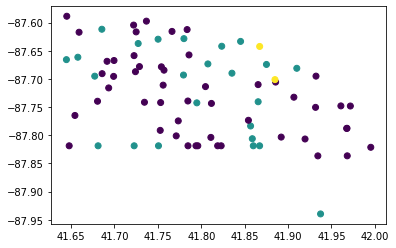

In [28]:
plt.scatter(mapping_kmeans['Latitude'], mapping_kmeans['Longitude'], c = mapping_kmeans['Label'])

## Gaussian Mixture Models

In [89]:
from sklearn.mixture import GaussianMixture

# define the model
gm = GaussianMixture(n_components=3)
# fit model and predict clusters
yhat = gm.fit_predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
plt.figure(figsize=(15,15))
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
  	# create scatter of these samples
	#plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot

print('silhouette_score: ',silhouette_score(X, yhat, metric='euclidean', n_jobs=-1))
print('calinski_harabasz_score: ',calinski_harabasz_score(X, yhat))
print('davies_bouldin_score: ', davies_bouldin_score(X, yhat))

silhouette_score:  0.5176940110556133
calinski_harabasz_score:  132.0926757672917
davies_bouldin_score:  0.5712538887315413


<Figure size 1080x1080 with 0 Axes>

In [90]:
gmm_df = clustering_df_.copy()
gmm_df['Label'] = yhat
gmm_df.head(3)

,Median_Income,Mean_Income,arrest_rate,Label
Community_Area,,,,
1.0,54592.210320,76435.966637,0.163951,0
2.0,41813.912850,63755.237821,0.122120,0
3.0,62367.492937,86387.481583,0.170394,1


In [91]:
gmm_df[gmm_df['Label'] == 0].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,48.000000,48.000000,48.000000,48.0
mean,42283.831027,61024.236712,0.147251,0.0
std,8561.775612,10166.794871,0.041166,0.0
min,29521.269442,45816.079455,0.077063,0.0
25%,35473.181411,51676.839906,0.118953,0.0
50%,40873.377559,59420.844242,0.136747,0.0
75%,49001.641646,69378.537736,0.181635,0.0
max,60737.377359,83914.541622,0.242224,0.0


In [92]:
gmm_df[gmm_df['Label'] == 1].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,27.000000,27.000000,27.000000,27.0
mean,67675.360573,99168.823370,0.205256,1.0
std,13143.844207,18669.293138,0.068893,0.0
min,44267.991784,70909.137867,0.077380,1.0
25%,57807.055986,85780.256308,0.159913,1.0
50%,67524.938863,95478.883747,0.198257,1.0
75%,76573.438940,110852.502412,0.248187,1.0
max,100127.402297,143016.459104,0.390888,1.0


In [33]:
gmm_df[gmm_df['Label'] == 2].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,26.000000,26.000000,26.000000,26.0
mean,64912.948620,94893.916921,0.210627,2.0
std,11351.373412,15496.047490,0.068128,0.0
min,44267.991784,70430.878375,0.077380,2.0
25%,56216.525213,85085.155033,0.167650,2.0
50%,63564.213351,92318.486150,0.202508,2.0
75%,72867.866044,106634.540249,0.250762,2.0
max,87630.383655,131772.912035,0.390888,2.0


In [34]:
Community_Area_mapping_gmm = { row['Community_Area']: row['Label']  for i,row in gmm_df.reset_index().iterrows()}

In [35]:
mapping_gmm = mapping_.copy()
mapping_gmm["Label"] = mapping_gmm['Community_Area'].apply(lambda x: Community_Area_mapping_gmm[x])
mapping_gmm.head()

,Community_Area,Latitude,Longitude,Label
0,1.0,41.757067,-87.684558,0.0
1,2.0,41.865529,-87.710185,0.0
2,3.0,41.875155,-87.674394,2.0
3,4.0,41.885702,-87.705701,0.0
4,5.0,41.932245,-87.695130,0.0


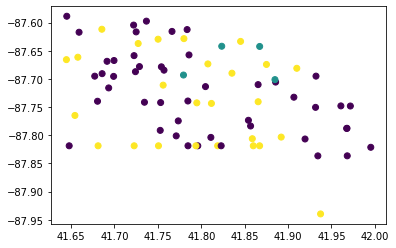

In [36]:
plt.scatter(mapping_gmm['Latitude'], mapping_gmm['Longitude'], c = mapping_gmm['Label'])

In [37]:
sum(mapping_gmm['Label'] == mapping_kmeans['Label']), sum(mapping_gmm['Label'] != mapping_kmeans['Label'])

(47, 30)

In [38]:
clustering_df_.iloc[0]

Median_Income    54592.210320
Mean_Income      76435.966637
arrest_rate          0.163951
Name: 1.0, dtype: float64

In [39]:
X[0]

array([5.45922103e+04, 7.64359666e+04, 1.63951228e-01])

In [43]:
gm.predict_proba([np.array([200, 10000000, 1000000])])

array([[0., 0., 1.]])

## Agglomerative Clustering

In [93]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=3)
# fit model and predict clusters
yhat_agg = model.fit_predict(X)
# retrieve unique clusters
clusters = np.unique(yhat_agg)
# create scatter plot for samples from each cluster
plt.figure(figsize=(15,15))
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = np.where(yhat == cluster)
	# create scatter of these samples
	#plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
#plt.show()

print('silhouette_score: ',silhouette_score(X, yhat_agg, metric='euclidean', n_jobs=-1))
print('calinski_harabasz_score: ',calinski_harabasz_score(X, yhat_agg))
print('davies_bouldin_score: ', davies_bouldin_score(X, yhat_agg))

silhouette_score:  0.603684220939078
calinski_harabasz_score:  118.43730588378023
davies_bouldin_score:  0.4132307700523093


<Figure size 1080x1080 with 0 Axes>

In [54]:
agg_df = clustering_df_.copy()
agg_df['Label'] = yhat_agg
agg_df.head(3)

,Median_Income,Mean_Income,arrest_rate,Label
Community_Area,,,,
1.0,54592.210320,76435.966637,0.163951,0
2.0,41813.912850,63755.237821,0.122120,0
3.0,62367.492937,86387.481583,0.170394,0


In [55]:
agg_df[agg_df['Label'] == 0].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,59.000000,59.000000,59.000000,59.0
mean,44718.469622,65085.251592,0.161624,0.0
std,9497.079906,12779.833800,0.057995,0.0
min,29521.269442,45816.079455,0.077063,0.0
25%,36952.840069,53977.518535,0.122634,0.0
50%,43744.082972,64842.802539,0.157431,0.0
75%,52388.556430,73795.184185,0.184645,0.0
max,62367.492937,90528.204899,0.390888,0.0


In [56]:
agg_df[agg_df['Label'] == 1].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,17.000000,17.000000,17.000000,17.0
mean,78865.692462,114472.709452,0.190657,1.0
std,14594.640997,22631.159005,0.058623,0.0
min,62616.236303,90648.377039,0.077380,1.0
25%,70194.986017,98445.666216,0.155264,1.0
50%,75743.338669,110354.136033,0.187625,1.0
75%,81296.976927,118513.249121,0.222736,1.0
max,122247.854779,179344.311460,0.309073,1.0


In [57]:
agg_df[agg_df['Label'] == 2].describe()

,Median_Income,Mean_Income,arrest_rate,Label
count,1.000000,1.000000,1.000000,1.0
mean,154970.682448,239173.042923,0.172619,2.0
std,NaN,NaN,NaN,NaN
min,154970.682448,239173.042923,0.172619,2.0
25%,154970.682448,239173.042923,0.172619,2.0
50%,154970.682448,239173.042923,0.172619,2.0
75%,154970.682448,239173.042923,0.172619,2.0
max,154970.682448,239173.042923,0.172619,2.0


In [59]:
Community_Area_mapping_agg = { row['Community_Area']: row['Label']  for i,row in agg_df.reset_index().iterrows()}

In [60]:
mapping_agg = mapping_.copy()
mapping_agg["Label"] = mapping_agg['Community_Area'].apply(lambda x: Community_Area_mapping_agg[x])
mapping_agg.head()

,Community_Area,Latitude,Longitude,Label
0,1.0,41.757067,-87.684558,0.0
1,2.0,41.865529,-87.710185,0.0
2,3.0,41.875155,-87.674394,0.0
3,4.0,41.885702,-87.705701,0.0
4,5.0,41.932245,-87.695130,0.0


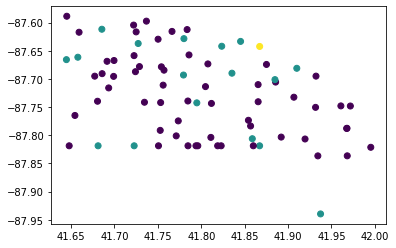

In [61]:
plt.scatter(mapping_agg['Latitude'], mapping_agg['Longitude'], c = mapping_agg['Label'])

## Classification using GMM cluster label

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [86]:
X_class = gmm_df.copy().drop(columns = ['Label'])
y_class = gmm_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2,random_state=1)

In [87]:
##Instantiate the classifier
dt = DecisionTreeClassifier(max_depth=2,random_state=1)
lr = LogisticRegression(random_state=1)
knn = KNeighborsClassifier()

In [88]:
Classifiers = {'LogisticRegression':lr,'KNearestNeighbors':knn,'DecisionTreeClassifier':dt}
for clf_name,clf in Classifiers.items():
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print('{:s}:{:.3f}'.format(clf_name,accuracy_score(y_test,y_pred)))

LogisticRegression:0.500
KNearestNeighbors:0.812
DecisionTreeClassifier:0.938
